In [71]:
# Copyright (c) 2023-2024 Pietro Luca Mazzacuva <pietroluca.mazzacuva@unicampus.it>
#
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
# THE SOFTWARE.

import pandas as pd
import numpy as np
import os, sys, pysam, gzip, subprocess, shlex, time
from datetime import datetime
from tqdm import tqdm
from multiprocessing import Pool
from sklearn.preprocessing import OneHotEncoder

def extraction(prefix,  AG_min, AGfreq_threshold, cov_threshold, interval):    
    
    starttime = datetime.now()

    editing = []
                                         
    with gzip.open(prefix+".gz") as redi:
        for c,l in enumerate(redi):
            line = l.decode("utf-8").rstrip().split("\t")
            if line[2] == "A":
                if int(line[3]) != 2:
                    if line[4] != "-":
                        if int(line[4]) >= cov_threshold:
                            if "AG" in line[7]:    
                                AG_rna = eval(line[6])[2]/sum(eval(line[6]))
                                if AG_rna >= AGfreq_threshold:
                                    if eval(line[6])[2] >= AG_min:
                                        editing.append(line)

            if c % 50000000 == 0:
                print(f"\tSites evaluated: {c}")
    print("Total evaluated rows:", c)
    editing = pd.DataFrame(editing)
    print("Total extracted Candidates Editing sites for current sample:", editing.shape[0])
    stoptime = datetime.now()
    print(f"[{datetime.now()}] Extraction of Editing Candidates finished for current sample. Elapsed time: {stoptime-starttime}.")
    columns = ["Region", "Position", "Ref", "Strand", "Cov", "Qual", "Bases", "AllSubs", "Freq", "gCov", "gQual", "g[A,C,G,T]", "gAllSubs", "gFreq"]
    editing.columns = columns
    print(f"[{datetime.now()}] Starting extraction of intervals.")
    ohe = OneHotEncoder()
    ohe.fit(np.array(["A", "C", "G", "T"]).reshape(-1, 1))

    intervals = []
    starttime_preds = datetime.now()
    total_extracted = 0
    features_extracted_filepath = prefix+ "_feature_vectors.tsv"
    features_extracted = open(features_extracted_filepath, "w")

    df = editing.query("Region != 'chrM'")
    print(f"[{datetime.now()}] Loading reditable with tabix and pysam:", prefix)
    start_time = datetime.now()
    srr = pysam.TabixFile(prefix+".gz")
    with tqdm(total=df.shape[0], position=0, leave=True) as pbar:
        for site in df.itertuples():
            start = int(site.Position) - ((interval-1)/2)
            stop = int(site.Position) + ((interval-1)/2)
            AGrna = eval(site.Bases)[2]/sum(eval(site.Bases))
            srr_interval = []
            for s in srr.fetch(site.Region, start-1, stop):
                srr_interval.append(s.split("\t"))
            srr_interval = pd.DataFrame(srr_interval, columns=columns)
            if srr_interval.shape[0] == interval and len(set(srr_interval["Strand"])) == 1:
                intervals.append([site.Region, site.Position, site.Ref, site.Strand, AGrna, site.Bases, start, stop, stop-start + 1, srr_interval.shape[0]])
                total_extracted += 1
                strand = site.Strand
                seq = srr_interval.Ref.values.reshape(-1,1)
                seq_ohe = ohe.transform(seq).toarray().T
                vects_freqs = []
                strands = []
                vects = []
                for vect in srr_interval["Bases"]:
                    vect = np.array(eval(vect))
                    cov = sum(vect)
                    vect_freqs = vect / cov
                    vects_freqs.append(vect_freqs)
                    vects.append(vect)
                vects_freqs = np.array(vects_freqs).T
                vects = np.array(vects).T
                encoded_site = pd.concat([pd.DataFrame(seq_ohe), pd.DataFrame(vects_freqs)])
                encoded_site.reset_index(drop=True, inplace=True)
                if strand == 0: 
                    encoded_site = pd.DataFrame(np.flip(encoded_site.values, axis=1))
                encoded_site.to_csv(features_extracted, mode="a", sep="\t", header = None, index=None)
            pbar.update(1)
    intervals = pd.DataFrame(intervals)
    print(f"[{datetime.now()}] Total extracted Editing sites: {total_extracted}.")
    stop_time_global = datetime.now()
    print(f"[{datetime.now()}] Features Extraction Finished. Elapsed time {datetime.now()-starttime_preds}.")
    features_extracted.close()
    
    intervals.columns = ["Region", "Position", "RefBase", "Strand", "FreqAGrna", "BasesCounts", "Start", "Stop", "Intlen", "TabixLen"]
    intervals.to_csv(prefix + "_intervals.tsv", sep="\t", index=None)
    print(f"[{datetime.now()}] Computation Finished. Total Elapsed time: {datetime.now()-starttime}")

def candidates_bona_fide_extraction(name1, name2, name3, path, cells, AG_min, AGfreq_threshold, cov_threshold, rna_cov_threshold):    

    starttime = datetime.now()
    sites = []
    
    wgs = pysam.TabixFile(f"{path}/{name3}.gz")   
    inactive = pysam.TabixFile(f"{path}/{name2}.gz")
    with gzip.open(f"{path}/{name1}.gz") as redi:

        for c,l in enumerate(redi):
            line = l.decode("utf-8").rstrip().split("\t")
            if line[0].find("chr") != -1:
                if line[2] == "A":
                    if int(line[3]) != 2:
                        if line[4] != "-":
                            if int(line[4]) >= cov_threshold:
                                if "AG" in line[7]:    
                                    AG_rna = eval(line[6])[2]/sum(eval(line[6]))
                                    if AG_rna >= AGfreq_threshold:
                                        if eval(line[6])[2] >= AG_min:
                                            region = line[0]
                                            start = int(line[1])-1
                                            stop = int(line[1])
                                            for ROW_inactive in inactive.fetch(region, start, stop):
                                                row_inactive = ROW_inactive.split("\t")
                                                if row_inactive[4] != "-":
                                                    if int(row_inactive[3]) != 2:
                                                        if int(row_inactive[4]) >= rna_cov_threshold:
                                                            sub_inactive = eval(row_inactive[6])[2]
                                                            for ROW_WGS in wgs.fetch(region, start, stop):
                                                                row_wgs = ROW_WGS.split("\t")
                                                                if row_wgs[4] !=  "-":
                                                                    if int(row_wgs[4])>=cov_threshold:
                                                                        sub_wgs = eval(row_wgs[6])[2]
                                                                        if sub_wgs == 0:
                                                                            if sub_inactive == 0:
                                                                                sites.append([line[0], line[1], 1])
                                                                        else:
                                                                            if sub_inactive >= AG_min:
                                                                                sites.append([line[0], line[1], 0])
                                                                                                               
            if c % 50000000 == 0:
                print(f"\tSites evaluated: {c}")
     
    sites = pd.DataFrame(sites)
    sites.columns = ["Region", "Position", "Class"]
    positives = sites[sites.loc[:, "Class"]==1].shape[0]
    negatives = sites[sites.loc[:, "Class"]==0].shape[0]
    print("Total evaluated rows:", c)
    print(f"Total extracted candidates bona fide Sites for {name1} {name2} samples: {sites.shape[0]}")
    print(f"Total candidates positives bona fide Sites for {name1} {name2} samples: {positives}")
    print(f"Total candidates negatives bona fide Sites for {name1} {name2} samples: {negatives}")
    stoptime = datetime.now()
    
    print(f"[{datetime.now()}] Extraction of candidates bonafide sites finished for {name1} {name2} samples. Elapsed time: {stoptime-starttime}.")
    sites.to_csv(f"{path}/{name1}_{name2}_candidates_bona_fide_sites.tsv", sep="\t", index=None)
                                                                                 
def bonafide_identification(path, rmsk, refseq):
                           
    u_path = "/lustrehome/pietrolucamazzacuva/filezilla-recas/scripts/utilities"                                                                            
                                                                                 
    for file_name in os.listdir(path):
        if file_name.find("_candidates_bona_fide_sites.tsv") !=-1:
            df = pd.read_csv(os.path.join(path, file_name), sep="\t")
            df.to_csv(os.path.join(path, file_name), sep="\t", index=None, header=False)
            name = file_name.replace(".tsv", "")
            cmd_sh = "python3 {}/AnnotateTablePython3.py -a {}/{} -n rmsk -i {}/{}.tsv -o {}/{}.out.rmsk -u".format(u_path, u_path, rmsk, path, name, path, name)
            args = shlex.split(cmd_sh)
            p = subprocess.Popen(args, env=dict(os.environ, PATH="/lustrehome/pietrolucamazzacuva/anaconda3/envs/tensorflow-gpu/bin"))

    time.sleep(300)

    for name in os.listdir(path):
        if name.find("rmsk") != -1:
            cmd_sh = "python3 {}/AnnotateTablePython3.py -a {}/{} -i {}/{} -o {}/{}.refseq -u".format(u_path, u_path, refseq, path, name, path, name)
            args = shlex.split(cmd_sh)
            p = subprocess.Popen(args, env=dict(os.environ, PATH="/lustrehome/pietrolucamazzacuva/anaconda3/envs/tensorflow-gpu/bin"))

    time.sleep(300)

    cols = ["Region", "Position", "Class", "RMSK-Rep", "RMSK-Reg", "RefSeq-Rep", "RefSeq-Reg"]
    for file_name in os.listdir(path):
        if file_name.find(".refseq") !=-1:
            df = pd.read_table(os.path.join(path, file_name), header=None)
            name = file_name.replace(".out.rmsk.refseq", "_annoted.tsv")
            df.columns = cols
            df.to_csv(os.path.join(path, name), sep="\t", index=None)

    for file_name in os.listdir(path):
        if file_name.find("candidates_bona_fide_sites_annoted.tsv") !=-1:
            bona_fide = pd.read_csv(os.path.join(path, file_name), sep="\t")
            rep = bona_fide[(bona_fide.iloc[:, 3] != "-") & (bona_fide.iloc[:, 4] != "-")]
            non_rep = bona_fide[(bona_fide.iloc[:, 3] == "-") & (bona_fide.iloc[:, 4] == "-")]

            del bona_fide

            non_rep_n = non_rep[non_rep.iloc[:, 2]==0]
            non_rep_p = non_rep[non_rep.iloc[:, 2]==1]

            del non_rep

            non_rep_p = non_rep_p[(non_rep_p.iloc[:, 5] != "-") & (non_rep_p.iloc[:, 6] != "-")]
            bona_fide = pd.concat([rep, non_rep_n, non_rep_p])

            del rep, non_rep_n, non_rep_p

            name = file_name.replace("candidates_bona_fide_sites_annoted.tsv", "bona_fide_sites.tsv")
            bona_fide = bona_fide.sort_values(["Region", "Position"])
            bona_fide.to_csv(os.path.join(path, name), sep="\t", index=None)
            
            
            
samples = ["outTable_853538513", "outTable_921089530"]

filespath = "/lustrehome/pietrolucamazzacuva/filezilla-recas/tissues/independent_datasets/U87"
rmsk_file_name = "rmsk.sorted.gtf.gz"
refseq_file_name = "hg19.ncbiRefSeq.sorted.gtf.gz"
wgs = "outTable_519021174"

min_dna_cov = 10
min_rna_cov = 30
min_AG_rate = 0.01
min_G = 2
seq_lenght = 101

inputs = []
for i in range(len(samples)):
    inputs.append([os.path.join(filespath, f"{samples[i]}"), min_G, min_AG_rate, min_rna_cov, seq_lenght])

with Pool(2) as pool:
    pool.starmap(extraction, inputs)
    
candidates_bona_fide_extraction(samples[0], samples[1], wgs, filespath, cells, min_G, 
                                min_AG_rate, min_dna_cov, min_rna_cov)     

bonafide_identification(filespath, rmsk_file_name, refseq_file_name)


	Sites evaluated: 0
	Sites evaluated: 0
	Sites evaluated: 50000000
	Sites evaluated: 50000000
	Sites evaluated: 100000000
	Sites evaluated: 100000000
	Sites evaluated: 150000000
	Sites evaluated: 150000000
	Sites evaluated: 200000000
	Sites evaluated: 200000000
Total evaluated rows: 213159783
Total extracted Candidates Editing sites for current sample: 7395
[2024-07-28 11:25:32.355352] Extraction of Editing Candidates finished for current sample. Elapsed time: 0:06:00.685702.
[2024-07-28 11:25:32.357116] Starting extraction of intervals.
[2024-07-28 11:25:32.371185] Loading reditable with tabix and pysam: /lustrehome/pietrolucamazzacuva/filezilla-recas/tissues/independent_datasets/U87/outTable_921089530


 93%|█████████▎| 6878/7372 [00:19<00:01, 414.74it/s]

Total evaluated rows: 225346133
Total extracted Candidates Editing sites for current sample: 9675
[2024-07-28 11:25:51.901873] Extraction of Editing Candidates finished for current sample. Elapsed time: 0:06:20.232841.
[2024-07-28 11:25:51.903549] Starting extraction of intervals.
[2024-07-28 11:25:51.916933] Loading reditable with tabix and pysam: /lustrehome/pietrolucamazzacuva/filezilla-recas/tissues/independent_datasets/U87/outTable_853538513


100%|██████████| 7372/7372 [00:20<00:00, 359.01it/s]


[2024-07-28 11:25:53.063104] Total extracted Editing sites: 2967.
[2024-07-28 11:25:53.064629] Features Extraction Finished. Elapsed time 0:00:20.705431.
[2024-07-28 11:25:53.081144] Computation Finished. Total Elapsed time: 0:06:21.411506


100%|██████████| 9654/9654 [00:25<00:00, 379.37it/s]


[2024-07-28 11:26:17.697716] Total extracted Editing sites: 3894.
[2024-07-28 11:26:17.699120] Features Extraction Finished. Elapsed time 0:00:25.793559.
[2024-07-28 11:26:17.722530] Computation Finished. Total Elapsed time: 0:06:46.053514
	Sites evaluated: 0
	Sites evaluated: 50000000
	Sites evaluated: 100000000
	Sites evaluated: 150000000
	Sites evaluated: 200000000
Total evaluated rows: 225346133
Total extracted candidates bona fide Sites for outTable_853538513 outTable_921089530 samples: 6380
Total candidates positives bona fide Sites for outTable_853538513 outTable_921089530 samples: 5387
Total candidates negatives bona fide Sites for outTable_853538513 outTable_921089530 samples: 993
[2024-07-28 11:37:05.524291] Extraction of candidates bonafide sites finished for outTable_853538513 outTable_921089530 samples. Elapsed time: 0:10:47.722925.


Pysam version used: 0.15.4
Script time --> START: 28/07/2024 11:37:08
Table saved on /lustrehome/pietrolucamazzacuva/filezilla-recas/tissues/independent_datasets/U87/outTable_853538513_outTable_921089530_candidates_bona_fide_sites.out.rmsk
Script time --> END: 28/07/2024 11:37:26
Pysam version used: 0.15.4
Script time --> START: 28/07/2024 11:42:06
Table saved on /lustrehome/pietrolucamazzacuva/filezilla-recas/tissues/independent_datasets/U87/outTable_853538513_outTable_921089530_candidates_bona_fide_sites.out.rmsk.refseq
Script time --> END: 28/07/2024 11:42:24


2024-07-29 12:32:17.397575: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-29 12:32:17.397650: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-29 12:32:17.397688: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-29 12:32:17.409892: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
100%|██████████| 2/2 [00:18<00:00,  9.20s/it]


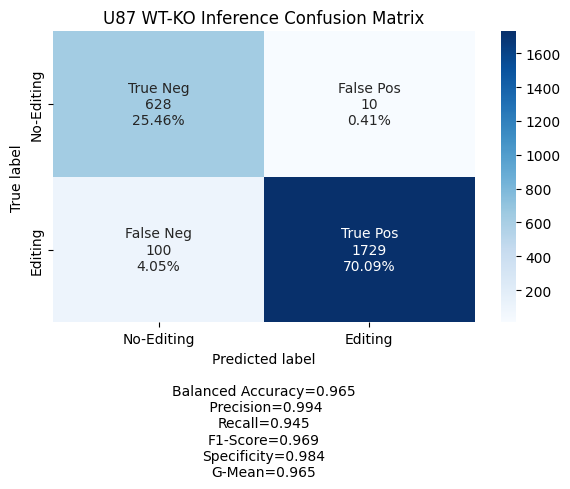

In [1]:
import os, sys, subprocess, shlex
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sn
import tensorflow as tf
import matplotlib.pyplot as plt
from  tensorflow import keras
from tqdm import tqdm
from REDInet import Utils
from functools import reduce

def return_chr_number(x):
    return x.replace("chr", "")


def make_predictions(tables, tables_filespath, model_filepath):
    
    model = tf.keras.models.load_model(model_filepath)
    with tqdm(total=int(len(tables)*len(tables[0]))) as pbar:
        for i in range(1):
            for j in range(2):

                intervals = pd.read_table(f"{tables_filespath}/{tables[i][j]}_intervals.tsv", sep="\t")
                X = pd.read_table(f"{tables_filespath}/{tables[i][j]}_feature_vectors.tsv", header=None, sep="\t")
                X_3d = Utils().from_2_to_3_dimensions(X, 8)
                X_3d_log2 = Utils().log_preprocessing(X_3d)
              
                output_table_prefix_filepath = "{}/{}_predictions.tsv".format(tables_filespath, tables[i][j])
                y_hat_proba = model.predict(X_3d_log2, batch_size=512, verbose=0)

                intervals["SNP_Probability"] = 1.0 - y_hat_proba
                intervals["Editing_Probability"] = y_hat_proba

                intervals.to_csv(output_table_prefix_filepath, sep="\t", index=None)
                pbar.update(1)
                
def bona_fide_metrics_calculator(tables, tables_filespath, cells):
    prefix = "U87"
    suffix_1 = "WT-KO"
              
    y_true = []
    y_pred = []
    for i in range(len(tables)):
              
        sites = pd.read_table(os.path.join(tables_filespath, f"{tables[i][0]}_{tables[i][1]}_bona_fide_sites.tsv"),
                              sep="\t", usecols=["Region", "Position", "Class"])
              
        cols =  ["Region", "Position", "Strand", "Editing_Probability"]
        wt = pd.read_csv(os.path.join(tables_filespath, f"{tables[i][0]}_predictions.tsv"), sep="\t", usecols=cols)
        adars_inactive = pd.read_csv(os.path.join(tables_filespath, f"{tables[i][1]}_predictions.tsv"), sep="\t", usecols=cols)
        
        wt.loc[:, "index_wt"] = wt.index.tolist()
        adars_inactive.loc[:, "index_adars_inactive"] = adars_inactive.index.tolist()
        merged = wt.merge(adars_inactive, how ="inner", on=["Region", "Position", "Strand"])
        merged = merged.merge(sites, how="inner", on=["Region", "Position"])
        common_pos = merged[merged.loc[:, "Class"]==1]
        index_common_pos = common_pos.loc[:, "index_wt"].tolist()
        merged = merged[merged.loc[:, "Class"]==0]
        index_adars_inactive = merged.loc[:, "index_adars_inactive"].tolist()
        index_wt = merged.loc[:, "index_wt"].tolist()
        snps_adars_inactive = adars_inactive.iloc[index_adars_inactive, :]
        snps_wt = wt.iloc[index_wt, :]
        snps = pd.concat([snps_wt, snps_adars_inactive], axis=0)
        snps.drop(["index_wt", "index_adars_inactive"], axis=1, inplace=True)
        snps.reset_index(drop=True, inplace=True)
        index_drop = index_common_pos + index_wt
        index_drop.sort()
        pos = wt.drop(index_drop)
        pos.reset_index(drop=True, inplace=True)
        pos = pos.merge(sites, how="inner", on=["Region", "Position"])
        pos.reset_index(drop=True, inplace=True)
        
        y_true += [1 for i in range(len(pos))] + [0 for i in range(len(snps))]
        y_pred += pos.loc[:, "Editing_Probability"].tolist() + snps.loc[:, "Editing_Probability"].tolist()

        pos.loc[:, "Class"] = 1
        snps.loc[:, "Class"] = 0
        pos = pos.loc[:, ["Region", "Position", "Class"]]
        snps = snps.loc[:, ["Region", "Position", "Class"]]
        
        editpredictsites = pd.concat([pos, snps], axis=0).loc[:, ["Region", "Position", "Class"]]
        editpredictsites.to_csv(f"{tables_filespath}/bona_fide_final_sites.tsv", index=None, sep="\t")
        editpredictsites.loc[:, "Region"] = editpredictsites.loc[:, "Region"].apply(return_chr_number)
        editpredictsites.to_csv(f"{tables_filespath}/editpredict_check_sites.tsv", index=None, sep="\t", header=False)
        
    Utils().make_confusion_matrix(y_true,  y_pred,
                                  title = f"{prefix} {suffix_1} Inference Confusion Matrix",
                                  figsize=(6,5),
                                  path=os.path.join(tables_filespath, f"{cells}_{suffix_1}_Inference_Conf_Matrix_on.tiff"))
    
    
cells = "U87"
tables = [["outTable_853538513", "outTable_921089530"]]
filespath = "/lustrehome/pietrolucamazzacuva/filezilla-recas/tissues/independent_datasets/U87"
model_filepath = "/lustrehome/pietrolucamazzacuva/filezilla-recas/REDInet_models/REDInet_log_preprocessing_pos_zeros_snps_29_02_2024_22_25_45.h5"

make_predictions(tables, filespath, model_filepath)
bona_fide_metrics_calculator(tables, filespath, cells)

In [11]:
import subprocess, time


path = "/lustrehome/pietrolucamazzacuva/filezilla-recas/tissues/independent_datasets/U87"
u_path = "/lustrehome/pietrolucamazzacuva/filezilla-recas/scripts/utilities"     
rmsk = "rmsk.sorted.gtf.gz"
name = "editpredict_check_sites"

cmd_sh = "python3 {}/AnnotateTablePython3.py -a {}/{} -n rmsk -i {}/{}.tsv -o {}/{}.out.rmsk -u".format(u_path, u_path, rmsk, path, name, path, name)
args = shlex.split(cmd_sh)
p = subprocess.Popen(args, env=dict(os.environ, PATH="/lustrehome/pietrolucamazzacuva/anaconda3/envs/tensorflow-gpu/bin"))

time.sleep(60)


df = pd.read_table(f"{path}/editpredict_check_sites.out.rmsk", header=None)
alu = df[df.iloc[:, 4].str.find("Alu")!=-1]
alu = alu.iloc[:, [0,1]]
non_alu = df[df.iloc[:, 4].str.find("Alu")==-1]
non_alu = non_alu.iloc[:, [0,1]]

alu.columns = ["Region", "Position"]
alu.sort_values(["Region", "Position"], inplace=True)

non_alu.columns = ["Region", "Position"]
non_alu.sort_values(["Region", "Position"], inplace=True)


alu.iloc[:, [0,1]].to_csv(f"{path}/editpredict_check_sites_alu.txt", index=None, header=False, sep="\t")
non_alu.iloc[:, [0,1]].to_csv(f"{path}/editpredict_check_sites_non_alu.txt", index=None, header=False, sep="\t")

Pysam version used: 0.15.4
Script time --> START: 28/07/2024 22:03:31
Table saved on /lustrehome/pietrolucamazzacuva/filezilla-recas/tissues/independent_datasets/U87/editpredict_check_sites.out.rmsk
Script time --> END: 28/07/2024 22:03:32


In [16]:
import os
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn import metrics

def return_region(x):
    return "chr{}".format(x)

save_path = "/lustrehome/pietrolucamazzacuva/filezilla-recas/tissues/independent_datasets/U87"

bonafide = pd.read_table(os.path.join(save_path, "bona_fide_final_sites.tsv"))
bonafide.loc[:, "Position"] = bonafide.loc[:, "Position"].astype("int32")

cols = ["Chromosome", "Position", "YES_prob"]

edi = pd.read_table(os.path.join(save_path, "U87_EditPreditc_results.txt"), usecols=cols)

edi.columns = ["Region", "Position", "EditPredict_Probability"]
edi.loc[:, "Region"] = edi.loc[:, "Region"].apply(return_region)
edi.dropna(axis=0, inplace=True)
edi.loc[:, "Position"] = edi.loc[:, "Position"].astype("int32")

merged = edi.merge(bonafide, how="inner", on=["Region", "Position"])
merged.drop_duplicates(keep="first", inplace=True)

redi = pd.concat([pd.read_table(f"{save_path}/outTable_853538513_predictions.tsv", usecols=["Region", "Position", "Editing_Probability"]),
                  pd.read_table(f"{save_path}/outTable_921089530_predictions.tsv", usecols=["Region", "Position", "Editing_Probability"])])

redi.columns = ["Region", "Position", "REDInet_Probability"]

merged = merged.merge(redi, how="inner", on=["Region", "Position"])

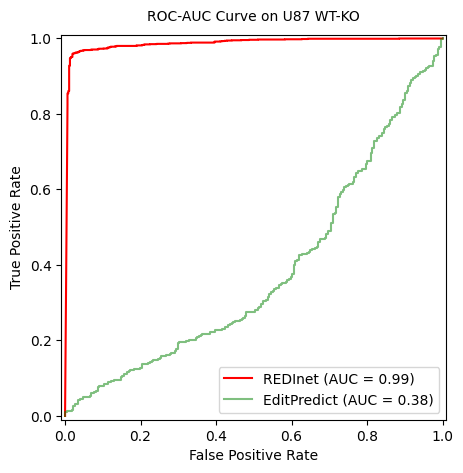

In [17]:
redi_true = edi_true = merged.loc[:, "Class"].tolist()
redi_pred = merged.loc[:, "REDInet_Probability"].tolist()
edi_pred = merged.loc[:, "EditPredict_Probability"].tolist()

fig, ax = plt.subplots(figsize=(5.5, 5))
fpr_redi, tpr_redi, thresholds_redi = metrics.roc_curve(redi_true, redi_pred)
AUC_redi = metrics.auc(fpr_redi, tpr_redi,)
ROC = metrics.RocCurveDisplay(fpr=fpr_redi, tpr=tpr_redi, roc_auc=AUC_redi).plot(ax=ax, color="red", name="REDInet")
fpr_edi, tpr_edi, thresholds_edi = metrics.roc_curve(edi_true, edi_pred)
AUC_edi = metrics.auc(fpr_edi, tpr_edi)
ROC_edi = metrics.RocCurveDisplay(fpr=fpr_edi, tpr=tpr_edi, roc_auc=AUC_edi).plot(ax=ax, color="green", name="EditPredict", alpha=0.5) 

ax.set_title(f"ROC-AUC Curve on U87 WT-KO", fontsize=10, pad=10)
plt.savefig(f"{save_path}/ROC-AUC_on_U87_WT_KO.tiff", dpi=600, facecolor='white', transparent=False) 
plt.show()

In [2]:
import pandas as pd
import os, math

tablesfilespath = "/lustrehome/pietrolucamazzacuva/filezilla-recas/tissues/independent_datasets/U87"

tables = ["outTable_853538513", "outTable_921089530"]


sites = pd.read_table(os.path.join(tablesfilespath, f"{tables[0]}_{tables[1]}_bona_fide_sites.tsv"),
                      sep="\t", usecols=["Region", "Position", "Class"])
      
cols =  ["Region", "Position", "Strand", "Predicted_Class"]
wt = pd.read_table(os.path.join(tablesfilespath+"/Package_Test", f"{tables[0]}_predictions.txt"), sep="\t", usecols=cols)
adars_inactive = pd.read_table(os.path.join(tablesfilespath+"/Package_Test", f"{tables[1]}_predictions.txt"), sep="\t", usecols=cols)

wt.loc[:, "index_wt"] = wt.index.tolist()
adars_inactive.loc[:, "index_adars_inactive"] = adars_inactive.index.tolist()
merged = wt.merge(adars_inactive, how ="inner", on=["Region", "Position", "Strand"])
merged = merged.merge(sites, how="inner", on=["Region", "Position"])
common_pos = merged[merged.loc[:, "Class"]==1]
index_common_pos = common_pos.loc[:, "index_wt"].tolist()
merged = merged[merged.loc[:, "Class"]==0]
index_adars_inactive = merged.loc[:, "index_adars_inactive"].tolist()
index_wt = merged.loc[:, "index_wt"].tolist()
snps_adars_inactive = adars_inactive.iloc[index_adars_inactive, :]
snps_wt = wt.iloc[index_wt, :]
snps = pd.concat([snps_wt, snps_adars_inactive], axis=0)
snps.drop(["index_wt", "index_adars_inactive"], axis=1, inplace=True)
snps.reset_index(drop=True, inplace=True)
index_drop = index_common_pos + index_wt
index_drop.sort()
pos = wt.drop(index_drop)
pos.reset_index(drop=True, inplace=True)
pos = pos.merge(sites, how="inner", on=["Region", "Position"])
pos.reset_index(drop=True, inplace=True)

pos.drop("Class", axis=1, inplace=True)

pos.loc[:, "Class"] = "Editing"
snps.loc[:, "Class"] = "Not_Editing"

real_class =  pos.loc[:, "Class"].tolist() + snps.loc[:, "Class"].tolist()
predicted_class = pos.loc[:, "Predicted_Class"].tolist() + snps.loc[:, "Predicted_Class"].tolist()

print(len(predicted_class))
print(len(real_class))

2467
2467


In [3]:
TP = 0
FN = 0
TN = 0
FP = 0

for i in range(len(real_class)):
    if predicted_class[i] == "Editing":
        if real_class[i] == "Editing":
            TP += 1
        else:
            FP += 1
    else:
        if real_class[i] == "Editing":
            FN += 1
        else:
            TN += 1

precision = TP/(TP+FP)
recall = TP/(TP+FN)
specificity = TN/(TN+FP)
g_mean = math.sqrt(recall*specificity)
f1_score = 2*TP/(2*TP+FP+FN)
balanced_accuracy = 0.5 * (recall+specificity)


print(f"Balanced Accuracy={round(balanced_accuracy, 3)}")
print(f"Precision={round(precision, 3)}")
print(f"Recall={round(recall, 3)}")
print(f"F1-Score={round(f1_score, 3)}")
print(f"Specificity={round(specificity, 3)}")
print(f"G-Mean={round(g_mean, 3)}")


Balanced Accuracy=0.965
Precision=0.994
Recall=0.945
F1-Score=0.969
Specificity=0.984
G-Mean=0.965


In [47]:
import pandas as pd
import os


tablesfilespath = "/lustrehome/pietrolucamazzacuva/filezilla-recas/tissues/independent_datasets/U87"

tables = ["outTable_853538513", "outTable_921089530"]

for table in tables:
    notebook = pd.read_table(os.path.join(tablesfilespath, table+"_predictions.tsv"), usecols=["Region", "Position"])
    package = pd.read_table(os.path.join(tablesfilespath+"/Package_Test", table+"_predictions.txt"), usecols=["Region", "Position"])
    merged = notebook.merge(package, how="inner", on=["Region", "Position"])
    print(len(notebook), len(merged))

3894 3894
2967 2967
